In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inferences)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.3.0+cu121'

## Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical reprresentation

In [3]:
# Create *known* variables
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze adds the brackets that we'll need later on
y = weight * X * bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.0000],
         [0.0042],
         [0.0084],
         [0.0126],
         [0.0168],
         [0.0210],
         [0.0252],
         [0.0294],
         [0.0336],
         [0.0378]]))

### Slitting data into training and test sets (one of the most important concepts in ML)
Let's create a training and test set with our data

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's  motto comes in!
"Visualize, visualize, visualize!"

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Training data")

  # Are there predictiopns
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

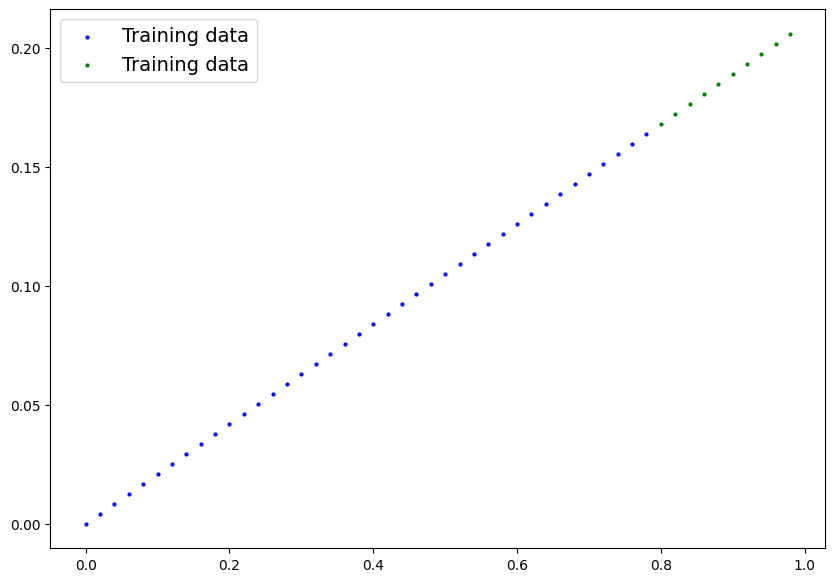

In [6]:
plot_predictions();

### Build Model

What our model does:
* start with random values (weight and bias)
* look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms
1. Gradient descent
2. Backpropagation

In [7]:
from torch import nn

# create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch comes from nn.Module (base class for all nueral network modules)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula


### PyTorch model building essentials

* torch.nn - contains all of the buldings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim = this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...
So we can check our model parameters or what's inside our model using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict() # move these values to ideal values of weight and bias (set before)

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.config/

When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred
# with torch.no_grad():
  # y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.1680],
        [0.1722],
        [0.1764],
        [0.1806],
        [0.1848],
        [0.1890],
        [0.1932],
        [0.1974],
        [0.2016],
        [0.2058]])

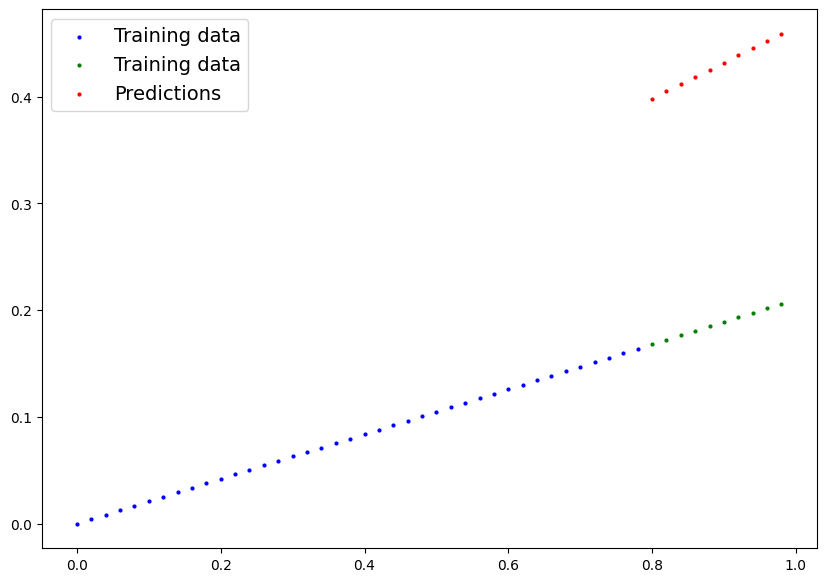

In [13]:
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters

Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we'll refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts. the model's parameters (eg weight and bias) to improve the loss function.
  * Inside the optimizer you'll often have to set two parameters
    * `params` - the model parameters you'd like to optimize
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step

And specifically, for PyTorch we need:
* a training loop
* a testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate <- possibly the most important hyperparameter (something we set) you can set

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [17]:
model_0.parameters()

<generator object Module.parameters at 0x7a2474a93450>

In [18]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop though the data
for epoch in range(epochs):
  # set model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default, how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 first

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaulation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.17821863293647766 | Test loss: 0.22809283435344696
OrderedDict([('weights', tensor([0.3328])), ('bias', tensor([0.1188]))])
Epoch: 10 | Loss: 0.06300870329141617 | Test loss: 0.09338293969631195
OrderedDict([('weights', tensor([0.2938])), ('bias', tensor([0.0188]))])
Epoch: 20 | Loss: 0.01129001285880804 | Test loss: 0.025797033682465553
OrderedDict([('weights', tensor([0.2645])), ('bias', tensor([-0.0227]))])
Epoch: 30 | Loss: 0.007851206697523594 | Test loss: 0.0175245963037014
OrderedDict([('weights', tensor([0.2473])), ('bias', tensor([-0.0157]))])
Epoch: 40 | Loss: 0.0044124070554971695 | Test loss: 0.009252198040485382
OrderedDict([('weights', tensor([0.2302])), ('bias', tensor([-0.0087]))])
Epoch: 50 | Loss: 0.009151091799139977 | Test loss: 0.0006053060060366988
OrderedDict([('weights', tensor([0.2160])), ('bias', tensor([-0.0047]))])
Epoch: 60 | Loss: 0.009151091799139977 | Test loss: 0.0006053060060366988
OrderedDict([('weights', tensor([0.2160])), ('bias',

Text(0.5, 0, 'Epochs')

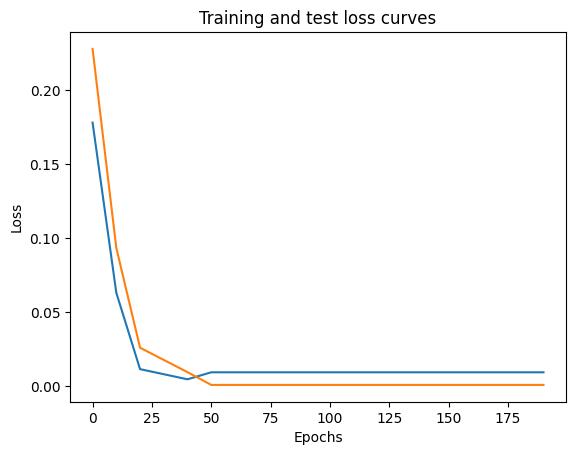

In [19]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.2199])), ('bias', tensor([0.0053]))])

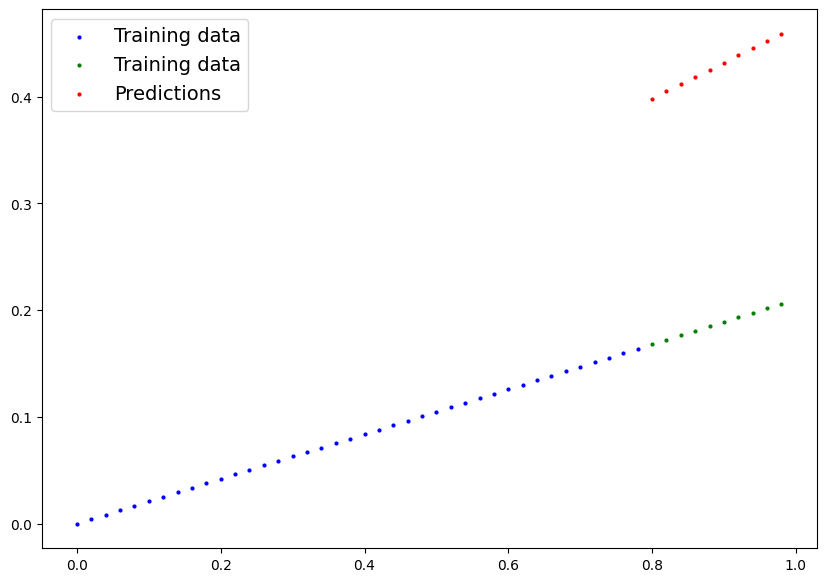

In [21]:
plot_predictions(predictions=y_preds)

In [22]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

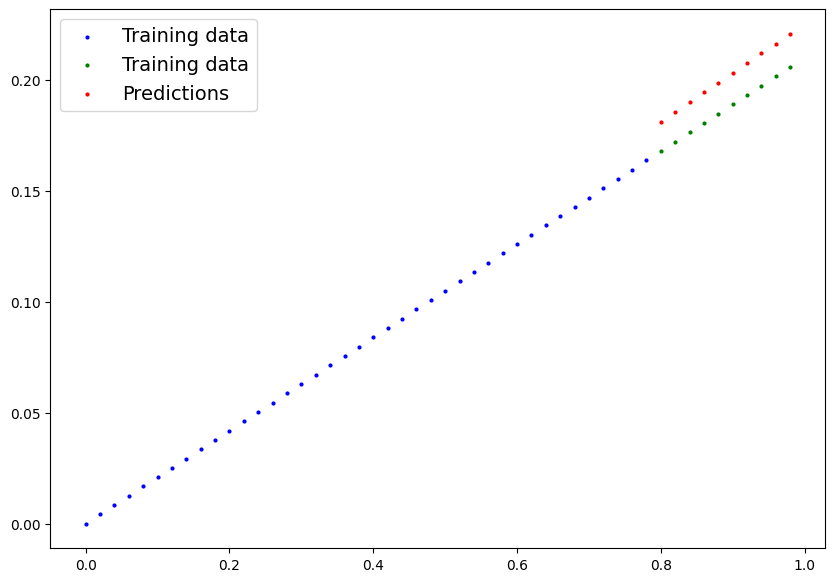

In [23]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch
1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

In [24]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [25]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.2199])), ('bias', tensor([0.0053]))])

In [27]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.1812],
        [0.1856],
        [0.1900],
        [0.1944],
        [0.1988],
        [0.2032],
        [0.2076],
        [0.2120],
        [0.2164],
        [0.2208]])

In [28]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

## 6. Putting it all together

Let's go back through the steps above and put it all in one place

In [29]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it, but if no GPU is available, the code will default to using CPU

In [30]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data

In [31]:
# Create some data using the lin reg formula of y = weight*X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [33]:
# Method for visualizing data using matplotlib
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Training data")

  # Are there predictiopns
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

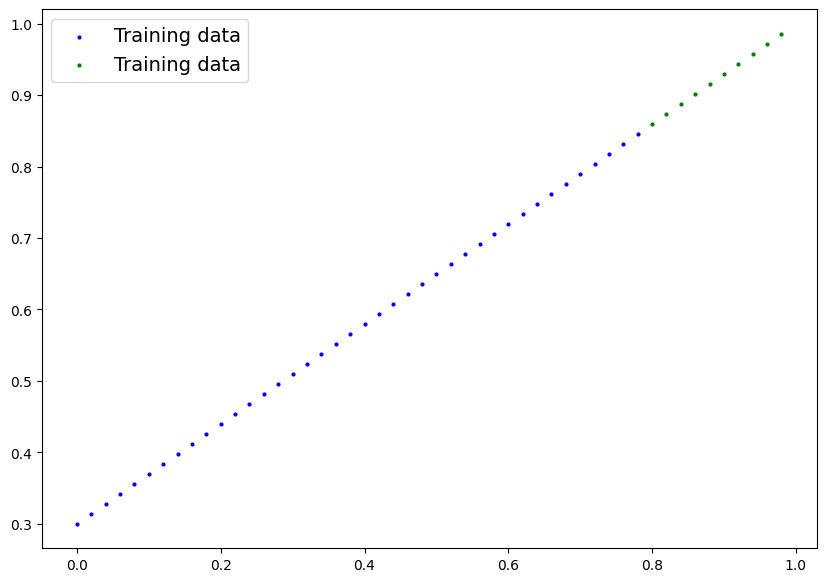

In [34]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

In [35]:
### Building a model
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [37]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [38]:
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [39]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimzer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [40]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [41]:
weight, bias

(0.7, 0.3)

In [42]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

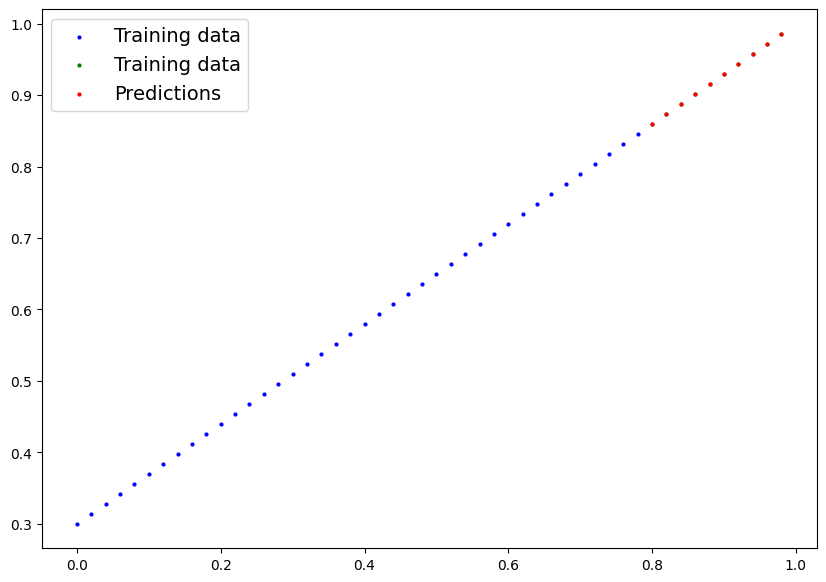

In [43]:
plot_predictions(predictions=y_preds.cpu())

In [44]:
## Saving and loading a trained model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [45]:
# Load a PyTorch model

# Create a new instance of linear regression model v2
loaded_model_1 = LinearRegressionModelV2()

# Load the model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [46]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [47]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [48]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds # check if they are the same (they should be)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')